In [1]:
import dlc_practical_prologue as prologue

In [2]:
import torch
import time
import numpy as np
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
#Sometimes download directly will have http403 error
from six.moves import urllib
# have to add a header to your urllib request (due to that site moving to Cloudflare protection)
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#*********************** 

In [4]:
# load training and testing data
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

In [5]:
print(train_input.shape)
print(train_classes.shape)
print(train_target.shape)
print(test_input.shape)
print(test_classes.shape)
print(test_target.shape)

torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])
torch.Size([1000, 2, 14, 14])
torch.Size([1000, 2])
torch.Size([1000])


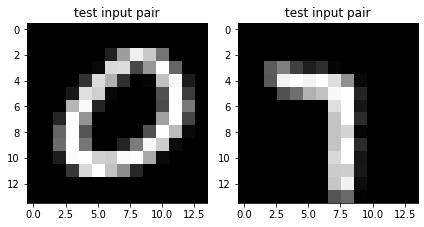

The test classes are: 0 and 7.
The test target is: 0


In [6]:
# discribe the data
fig = plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.imshow(test_input[0][i], cmap='gray')
  plt.title("test input pair")  
  plt.tight_layout()
plt.show()
print("The test classes are: %d and %d."%(test_classes[0][0].item(),test_classes[0][1].item()))
print("The test target is: %d"%(train_target[0]))

In [7]:
#weights_sharing_CNN
class CNN_Net_weight_sharing(nn.Module):
    def __init__(self):
        super(CNN_Net_weight_sharing, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,kernel_size=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv2_drop=nn.Dropout2d()
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128,2)
        #parameters
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=2e-3)

    def forward(self, x):
    
        img1 = x[:,0,:,:].view(-1,1,14,14)
        img2 = x[:,1,:,:].view(-1,1,14,14)
        
        img1 = F.relu(F.max_pool2d(self.conv1(img1), kernel_size=2, stride=2))
        img1 = F.relu(F.max_pool2d(self.conv2(img1), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.conv1(img2), kernel_size=2, stride=2))
        img2 = F.relu(F.max_pool2d(self.conv2(img2), kernel_size=2, stride=2))
        output = torch.cat((img1.view(-1, 256),img2.view(-1, 256)),1)
        output = F.relu(self.fc1(output))
        output = self.fc2(output)
        output = F.dropout(output,training=self.training)
        
        return output

        # Training Function

    def trainer(self, train_input, train_target, test_input, test_target):
        """
        Train the model on a training set
        :param train_input: Training features
        :param train_target: Training labels
        """
        
        start_time = time.time()
        train_loss_history=[]
        test_loss_history=[]
        train_accuracy=[]
        test_accuracy=[]
        for epoch in range(self.num_epochs):
            self.train()
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output = self(train_input[batch_idx:batch_idx+self.batch_size])
                target = train_target[batch_idx:batch_idx+self.batch_size]
                loss = self.criterion(output, target)  
                self.optimizer.zero_grad()                           #set the weight and bias gradients to zero
                loss.backward()                                #backpropagation
                self.optimizer.step()
                # print the loss in every 50 epoch
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
            
            # test mode
            self.eval()
            # get the training loss and accuracy
            train_predicted = self(train_input)
            train_loss = self.criterion(train_predicted, train_target)
            train_loss_history.append(train_loss)
            _, train_pred = torch.max(train_predicted, 1)   #return the index of the bigger result
            train_accuracy_result=self.compute_accuracy(train_target,train_pred)
            train_accuracy.append(train_accuracy_result)

            # get the testing loss and accuracy
            test_predicted = self(test_input)
            test_loss = self.criterion(test_predicted, test_target)
            test_loss_history.append(test_loss)
            _, test_pred = torch.max(test_predicted, 1)   #return the index of the bigger result
            test_accuracy_result=self.compute_accuracy(test_target,test_pred)
            test_accuracy.append(test_accuracy_result)

        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        
        #Setting-up the plot
        plt.figure(figsize=(15,8))

        ax1 = plt.subplot(1,2,1)

        ax2 = plt.subplot(1,2,2)

        #Drawing and labeling the curves
        ax1.plot(train_loss_history, label="Training Loss")
        ax1.plot(test_loss_history, label="Test Loss")

        #Adding the title and axis labels
        ax1.set_title('Train VS Test Loss')
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()

    #     #Saving the plot
    #     ax1.figure.savefig(model.model_name+'loss.png')


        #Drawing and labeling the curves
        ax2.plot(train_accuracy, label="Train Accuracy")
        ax2.plot(test_accuracy, label="Test Accuracy")

        #Adding the title and axis labels
        ax2.set_title('Train VS Test Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()

        # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
        #test mode
        self.eval()
        outputs= self(input_data)
        _, predicted = torch.max(outputs, 1)
        return 1-self.compute_accuracy(target,predicted)
    
    def compute_accuracy(self, target, pred):
        """
        Compute the training and testing error
        :param target: target data (whether 1 or 0)
        :param pred: predicted data
        :return 
        """
        return (target-pred).eq(0).float().mean().item()
    
    def save_model(self,model_name):
        """
        Save the model to a direction
        :param model_name: the model name, e.g. CNN_Net.pth
        """         
        torch.save(self, './model/'+ model_name)

In [8]:
# build the mdoel instance
my_model=CNN_Net_weight_sharing()
# save the model
my_model.save_model('CNN_Net_weight_sharing.pth')

Epoch: 001/025 | Batch 000/1000 | Loss: 4.637218
Epoch: 001/025 | Batch 050/1000 | Loss: 31.583828
Epoch: 001/025 | Batch 100/1000 | Loss: 25.168957
Epoch: 001/025 | Batch 150/1000 | Loss: 13.669436
Epoch: 001/025 | Batch 200/1000 | Loss: 9.752542
Epoch: 001/025 | Batch 250/1000 | Loss: 7.645481
Epoch: 001/025 | Batch 300/1000 | Loss: 3.577469
Epoch: 001/025 | Batch 350/1000 | Loss: 2.180454
Epoch: 001/025 | Batch 400/1000 | Loss: 1.521751
Epoch: 001/025 | Batch 450/1000 | Loss: 1.121722
Epoch: 001/025 | Batch 500/1000 | Loss: 1.458176
Epoch: 001/025 | Batch 550/1000 | Loss: 1.073254
Epoch: 001/025 | Batch 600/1000 | Loss: 0.738001
Epoch: 001/025 | Batch 650/1000 | Loss: 0.623563
Epoch: 001/025 | Batch 700/1000 | Loss: 0.740306
Epoch: 001/025 | Batch 750/1000 | Loss: 0.613559
Epoch: 001/025 | Batch 800/1000 | Loss: 0.627390
Epoch: 001/025 | Batch 850/1000 | Loss: 0.851993
Epoch: 001/025 | Batch 900/1000 | Loss: 0.599456
Epoch: 001/025 | Batch 950/1000 | Loss: 0.617301
Time elapsed: 0.0

Epoch: 009/025 | Batch 950/1000 | Loss: 0.461419
Time elapsed: 0.06 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.335677
Epoch: 010/025 | Batch 050/1000 | Loss: 0.248382
Epoch: 010/025 | Batch 100/1000 | Loss: 0.255967
Epoch: 010/025 | Batch 150/1000 | Loss: 0.320635
Epoch: 010/025 | Batch 200/1000 | Loss: 0.414706
Epoch: 010/025 | Batch 250/1000 | Loss: 0.310002
Epoch: 010/025 | Batch 300/1000 | Loss: 0.348341
Epoch: 010/025 | Batch 350/1000 | Loss: 0.297196
Epoch: 010/025 | Batch 400/1000 | Loss: 0.550054
Epoch: 010/025 | Batch 450/1000 | Loss: 0.386021
Epoch: 010/025 | Batch 500/1000 | Loss: 0.490617
Epoch: 010/025 | Batch 550/1000 | Loss: 0.322944
Epoch: 010/025 | Batch 600/1000 | Loss: 0.310057
Epoch: 010/025 | Batch 650/1000 | Loss: 0.226955
Epoch: 010/025 | Batch 700/1000 | Loss: 0.347449
Epoch: 010/025 | Batch 750/1000 | Loss: 0.248867
Epoch: 010/025 | Batch 800/1000 | Loss: 0.279482
Epoch: 010/025 | Batch 850/1000 | Loss: 0.405119
Epoch: 010/025 | Batch 900/1000 | Loss: 0.4071

Epoch: 018/025 | Batch 950/1000 | Loss: 0.177673
Time elapsed: 0.13 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.241249
Epoch: 019/025 | Batch 050/1000 | Loss: 0.149544
Epoch: 019/025 | Batch 100/1000 | Loss: 0.345094
Epoch: 019/025 | Batch 150/1000 | Loss: 0.290273
Epoch: 019/025 | Batch 200/1000 | Loss: 0.291261
Epoch: 019/025 | Batch 250/1000 | Loss: 0.279375
Epoch: 019/025 | Batch 300/1000 | Loss: 0.205439
Epoch: 019/025 | Batch 350/1000 | Loss: 0.184049
Epoch: 019/025 | Batch 400/1000 | Loss: 0.386297
Epoch: 019/025 | Batch 450/1000 | Loss: 0.271823
Epoch: 019/025 | Batch 500/1000 | Loss: 0.352112
Epoch: 019/025 | Batch 550/1000 | Loss: 0.365375
Epoch: 019/025 | Batch 600/1000 | Loss: 0.339975
Epoch: 019/025 | Batch 650/1000 | Loss: 0.158609
Epoch: 019/025 | Batch 700/1000 | Loss: 0.192555
Epoch: 019/025 | Batch 750/1000 | Loss: 0.247903
Epoch: 019/025 | Batch 800/1000 | Loss: 0.313165
Epoch: 019/025 | Batch 850/1000 | Loss: 0.273127
Epoch: 019/025 | Batch 900/1000 | Loss: 0.2851

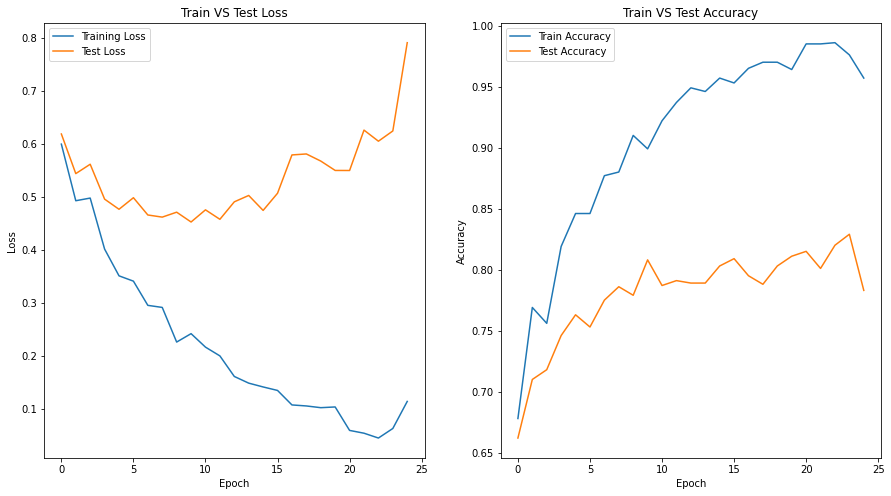

In [9]:
# train the model
my_model.trainer(train_input, train_target,test_input, test_target)

In [10]:
# output the total number of parameters
print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

The total number of the parameters is: 75202


Epoch: 001/025 | Batch 000/1000 | Loss: 4.962171
Epoch: 001/025 | Batch 050/1000 | Loss: 25.402122
Epoch: 001/025 | Batch 100/1000 | Loss: 14.572794
Epoch: 001/025 | Batch 150/1000 | Loss: 15.644885
Epoch: 001/025 | Batch 200/1000 | Loss: 3.532258
Epoch: 001/025 | Batch 250/1000 | Loss: 3.964733
Epoch: 001/025 | Batch 300/1000 | Loss: 5.032663
Epoch: 001/025 | Batch 350/1000 | Loss: 2.768125
Epoch: 001/025 | Batch 400/1000 | Loss: 1.463761
Epoch: 001/025 | Batch 450/1000 | Loss: 1.368678
Epoch: 001/025 | Batch 500/1000 | Loss: 1.619017
Epoch: 001/025 | Batch 550/1000 | Loss: 1.292605
Epoch: 001/025 | Batch 600/1000 | Loss: 0.793649
Epoch: 001/025 | Batch 650/1000 | Loss: 0.665662
Epoch: 001/025 | Batch 700/1000 | Loss: 1.306752
Epoch: 001/025 | Batch 750/1000 | Loss: 0.962226
Epoch: 001/025 | Batch 800/1000 | Loss: 0.628998
Epoch: 001/025 | Batch 850/1000 | Loss: 0.618701
Epoch: 001/025 | Batch 900/1000 | Loss: 0.671307
Epoch: 001/025 | Batch 950/1000 | Loss: 0.841119
Time elapsed: 0.0

Epoch: 009/025 | Batch 900/1000 | Loss: 0.292930
Epoch: 009/025 | Batch 950/1000 | Loss: 0.324921
Time elapsed: 0.07 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.316237
Epoch: 010/025 | Batch 050/1000 | Loss: 0.293355
Epoch: 010/025 | Batch 100/1000 | Loss: 0.337092
Epoch: 010/025 | Batch 150/1000 | Loss: 0.307212
Epoch: 010/025 | Batch 200/1000 | Loss: 0.303563
Epoch: 010/025 | Batch 250/1000 | Loss: 0.378761
Epoch: 010/025 | Batch 300/1000 | Loss: 0.326602
Epoch: 010/025 | Batch 350/1000 | Loss: 0.241402
Epoch: 010/025 | Batch 400/1000 | Loss: 0.236044
Epoch: 010/025 | Batch 450/1000 | Loss: 0.377430
Epoch: 010/025 | Batch 500/1000 | Loss: 0.361988
Epoch: 010/025 | Batch 550/1000 | Loss: 0.234901
Epoch: 010/025 | Batch 600/1000 | Loss: 0.260656
Epoch: 010/025 | Batch 650/1000 | Loss: 0.272974
Epoch: 010/025 | Batch 700/1000 | Loss: 0.289448
Epoch: 010/025 | Batch 750/1000 | Loss: 0.297148
Epoch: 010/025 | Batch 800/1000 | Loss: 0.429667
Epoch: 010/025 | Batch 850/1000 | Loss: 0.2088

Epoch: 018/025 | Batch 950/1000 | Loss: 0.223149
Time elapsed: 0.14 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.153439
Epoch: 019/025 | Batch 050/1000 | Loss: 0.208313
Epoch: 019/025 | Batch 100/1000 | Loss: 0.188021
Epoch: 019/025 | Batch 150/1000 | Loss: 0.217527
Epoch: 019/025 | Batch 200/1000 | Loss: 0.174839
Epoch: 019/025 | Batch 250/1000 | Loss: 0.206718
Epoch: 019/025 | Batch 300/1000 | Loss: 0.223297
Epoch: 019/025 | Batch 350/1000 | Loss: 0.227564
Epoch: 019/025 | Batch 400/1000 | Loss: 0.169614
Epoch: 019/025 | Batch 450/1000 | Loss: 0.176578
Epoch: 019/025 | Batch 500/1000 | Loss: 0.167586
Epoch: 019/025 | Batch 550/1000 | Loss: 0.104390
Epoch: 019/025 | Batch 600/1000 | Loss: 0.188533
Epoch: 019/025 | Batch 650/1000 | Loss: 0.121260
Epoch: 019/025 | Batch 700/1000 | Loss: 0.199060
Epoch: 019/025 | Batch 750/1000 | Loss: 0.133911
Epoch: 019/025 | Batch 800/1000 | Loss: 0.257283
Epoch: 019/025 | Batch 850/1000 | Loss: 0.132854
Epoch: 019/025 | Batch 900/1000 | Loss: 0.1743

Epoch: 002/025 | Batch 900/1000 | Loss: 0.598541
Epoch: 002/025 | Batch 950/1000 | Loss: 0.627505
Time elapsed: 0.01 min
Epoch: 003/025 | Batch 000/1000 | Loss: 0.509251
Epoch: 003/025 | Batch 050/1000 | Loss: 0.595663
Epoch: 003/025 | Batch 100/1000 | Loss: 0.525173
Epoch: 003/025 | Batch 150/1000 | Loss: 0.592864
Epoch: 003/025 | Batch 200/1000 | Loss: 0.529280
Epoch: 003/025 | Batch 250/1000 | Loss: 0.512364
Epoch: 003/025 | Batch 300/1000 | Loss: 0.605946
Epoch: 003/025 | Batch 350/1000 | Loss: 0.587353
Epoch: 003/025 | Batch 400/1000 | Loss: 0.559070
Epoch: 003/025 | Batch 450/1000 | Loss: 0.489690
Epoch: 003/025 | Batch 500/1000 | Loss: 0.532079
Epoch: 003/025 | Batch 550/1000 | Loss: 0.571425
Epoch: 003/025 | Batch 600/1000 | Loss: 0.654106
Epoch: 003/025 | Batch 650/1000 | Loss: 0.539220
Epoch: 003/025 | Batch 700/1000 | Loss: 0.541615
Epoch: 003/025 | Batch 750/1000 | Loss: 0.640985
Epoch: 003/025 | Batch 800/1000 | Loss: 0.729210
Epoch: 003/025 | Batch 850/1000 | Loss: 0.5421

Epoch: 011/025 | Batch 850/1000 | Loss: 0.632629
Epoch: 011/025 | Batch 900/1000 | Loss: 0.421875
Epoch: 011/025 | Batch 950/1000 | Loss: 0.391003
Time elapsed: 0.10 min
Epoch: 012/025 | Batch 000/1000 | Loss: 0.296930
Epoch: 012/025 | Batch 050/1000 | Loss: 0.354524
Epoch: 012/025 | Batch 100/1000 | Loss: 0.394555
Epoch: 012/025 | Batch 150/1000 | Loss: 0.439217
Epoch: 012/025 | Batch 200/1000 | Loss: 0.311991
Epoch: 012/025 | Batch 250/1000 | Loss: 0.286172
Epoch: 012/025 | Batch 300/1000 | Loss: 0.456299
Epoch: 012/025 | Batch 350/1000 | Loss: 0.277299
Epoch: 012/025 | Batch 400/1000 | Loss: 0.384126
Epoch: 012/025 | Batch 450/1000 | Loss: 0.326258
Epoch: 012/025 | Batch 500/1000 | Loss: 0.300104
Epoch: 012/025 | Batch 550/1000 | Loss: 0.366497
Epoch: 012/025 | Batch 600/1000 | Loss: 0.496460
Epoch: 012/025 | Batch 650/1000 | Loss: 0.421441
Epoch: 012/025 | Batch 700/1000 | Loss: 0.354706
Epoch: 012/025 | Batch 750/1000 | Loss: 0.382122
Epoch: 012/025 | Batch 800/1000 | Loss: 0.4947

Epoch: 020/025 | Batch 000/1000 | Loss: 0.248396
Epoch: 020/025 | Batch 050/1000 | Loss: 0.261473
Epoch: 020/025 | Batch 100/1000 | Loss: 0.236319
Epoch: 020/025 | Batch 150/1000 | Loss: 0.243613
Epoch: 020/025 | Batch 200/1000 | Loss: 0.217980
Epoch: 020/025 | Batch 250/1000 | Loss: 0.172506
Epoch: 020/025 | Batch 300/1000 | Loss: 0.323338
Epoch: 020/025 | Batch 350/1000 | Loss: 0.274243
Epoch: 020/025 | Batch 400/1000 | Loss: 0.232844
Epoch: 020/025 | Batch 450/1000 | Loss: 0.205581
Epoch: 020/025 | Batch 500/1000 | Loss: 0.280735
Epoch: 020/025 | Batch 550/1000 | Loss: 0.162052
Epoch: 020/025 | Batch 600/1000 | Loss: 0.183401
Epoch: 020/025 | Batch 650/1000 | Loss: 0.284728
Epoch: 020/025 | Batch 700/1000 | Loss: 0.312842
Epoch: 020/025 | Batch 750/1000 | Loss: 0.275725
Epoch: 020/025 | Batch 800/1000 | Loss: 0.217239
Epoch: 020/025 | Batch 850/1000 | Loss: 0.273523
Epoch: 020/025 | Batch 900/1000 | Loss: 0.262689
Epoch: 020/025 | Batch 950/1000 | Loss: 0.195404
Time elapsed: 0.19 m

Epoch: 003/025 | Batch 850/1000 | Loss: 0.536394
Epoch: 003/025 | Batch 900/1000 | Loss: 0.453039
Epoch: 003/025 | Batch 950/1000 | Loss: 0.511591
Time elapsed: 0.02 min
Epoch: 004/025 | Batch 000/1000 | Loss: 0.541167
Epoch: 004/025 | Batch 050/1000 | Loss: 0.530627
Epoch: 004/025 | Batch 100/1000 | Loss: 0.572590
Epoch: 004/025 | Batch 150/1000 | Loss: 0.589879
Epoch: 004/025 | Batch 200/1000 | Loss: 0.427982
Epoch: 004/025 | Batch 250/1000 | Loss: 0.519066
Epoch: 004/025 | Batch 300/1000 | Loss: 0.522888
Epoch: 004/025 | Batch 350/1000 | Loss: 0.455161
Epoch: 004/025 | Batch 400/1000 | Loss: 0.500364
Epoch: 004/025 | Batch 450/1000 | Loss: 0.497673
Epoch: 004/025 | Batch 500/1000 | Loss: 0.490508
Epoch: 004/025 | Batch 550/1000 | Loss: 0.544452
Epoch: 004/025 | Batch 600/1000 | Loss: 0.479145
Epoch: 004/025 | Batch 650/1000 | Loss: 0.497773
Epoch: 004/025 | Batch 700/1000 | Loss: 0.544270
Epoch: 004/025 | Batch 750/1000 | Loss: 0.479198
Epoch: 004/025 | Batch 800/1000 | Loss: 0.6692

Epoch: 012/025 | Batch 000/1000 | Loss: 0.320491
Epoch: 012/025 | Batch 050/1000 | Loss: 0.325510
Epoch: 012/025 | Batch 100/1000 | Loss: 0.312279
Epoch: 012/025 | Batch 150/1000 | Loss: 0.261072
Epoch: 012/025 | Batch 200/1000 | Loss: 0.233941
Epoch: 012/025 | Batch 250/1000 | Loss: 0.305531
Epoch: 012/025 | Batch 300/1000 | Loss: 0.220783
Epoch: 012/025 | Batch 350/1000 | Loss: 0.225003
Epoch: 012/025 | Batch 400/1000 | Loss: 0.320303
Epoch: 012/025 | Batch 450/1000 | Loss: 0.236907
Epoch: 012/025 | Batch 500/1000 | Loss: 0.281079
Epoch: 012/025 | Batch 550/1000 | Loss: 0.262342
Epoch: 012/025 | Batch 600/1000 | Loss: 0.289040
Epoch: 012/025 | Batch 650/1000 | Loss: 0.422435
Epoch: 012/025 | Batch 700/1000 | Loss: 0.240371
Epoch: 012/025 | Batch 750/1000 | Loss: 0.289388
Epoch: 012/025 | Batch 800/1000 | Loss: 0.321599
Epoch: 012/025 | Batch 850/1000 | Loss: 0.277700
Epoch: 012/025 | Batch 900/1000 | Loss: 0.218847
Epoch: 012/025 | Batch 950/1000 | Loss: 0.285408
Time elapsed: 0.12 m

Epoch: 020/025 | Batch 750/1000 | Loss: 0.241891
Epoch: 020/025 | Batch 800/1000 | Loss: 0.160564
Epoch: 020/025 | Batch 850/1000 | Loss: 0.291782
Epoch: 020/025 | Batch 900/1000 | Loss: 0.242057
Epoch: 020/025 | Batch 950/1000 | Loss: 0.169722
Time elapsed: 0.20 min
Epoch: 021/025 | Batch 000/1000 | Loss: 0.256350
Epoch: 021/025 | Batch 050/1000 | Loss: 0.166994
Epoch: 021/025 | Batch 100/1000 | Loss: 0.259560
Epoch: 021/025 | Batch 150/1000 | Loss: 0.160216
Epoch: 021/025 | Batch 200/1000 | Loss: 0.162556
Epoch: 021/025 | Batch 250/1000 | Loss: 0.152431
Epoch: 021/025 | Batch 300/1000 | Loss: 0.116982
Epoch: 021/025 | Batch 350/1000 | Loss: 0.156669
Epoch: 021/025 | Batch 400/1000 | Loss: 0.206750
Epoch: 021/025 | Batch 450/1000 | Loss: 0.134957
Epoch: 021/025 | Batch 500/1000 | Loss: 0.141409
Epoch: 021/025 | Batch 550/1000 | Loss: 0.151533
Epoch: 021/025 | Batch 600/1000 | Loss: 0.169633
Epoch: 021/025 | Batch 650/1000 | Loss: 0.146617
Epoch: 021/025 | Batch 700/1000 | Loss: 0.2520

Epoch: 004/025 | Batch 000/1000 | Loss: 0.554235
Epoch: 004/025 | Batch 050/1000 | Loss: 0.497806
Epoch: 004/025 | Batch 100/1000 | Loss: 0.563942
Epoch: 004/025 | Batch 150/1000 | Loss: 0.596238
Epoch: 004/025 | Batch 200/1000 | Loss: 0.629431
Epoch: 004/025 | Batch 250/1000 | Loss: 0.565570
Epoch: 004/025 | Batch 300/1000 | Loss: 0.625021
Epoch: 004/025 | Batch 350/1000 | Loss: 0.490324
Epoch: 004/025 | Batch 400/1000 | Loss: 0.646973
Epoch: 004/025 | Batch 450/1000 | Loss: 0.555408
Epoch: 004/025 | Batch 500/1000 | Loss: 0.498442
Epoch: 004/025 | Batch 550/1000 | Loss: 0.589998
Epoch: 004/025 | Batch 600/1000 | Loss: 0.638864
Epoch: 004/025 | Batch 650/1000 | Loss: 0.503807
Epoch: 004/025 | Batch 700/1000 | Loss: 0.446827
Epoch: 004/025 | Batch 750/1000 | Loss: 0.595708
Epoch: 004/025 | Batch 800/1000 | Loss: 0.587885
Epoch: 004/025 | Batch 850/1000 | Loss: 0.534601
Epoch: 004/025 | Batch 900/1000 | Loss: 0.457325
Epoch: 004/025 | Batch 950/1000 | Loss: 0.503575
Time elapsed: 0.03 m

Epoch: 012/025 | Batch 850/1000 | Loss: 0.343138
Epoch: 012/025 | Batch 900/1000 | Loss: 0.298905
Epoch: 012/025 | Batch 950/1000 | Loss: 0.320250
Time elapsed: 0.10 min
Epoch: 013/025 | Batch 000/1000 | Loss: 0.328701
Epoch: 013/025 | Batch 050/1000 | Loss: 0.243281
Epoch: 013/025 | Batch 100/1000 | Loss: 0.323498
Epoch: 013/025 | Batch 150/1000 | Loss: 0.306460
Epoch: 013/025 | Batch 200/1000 | Loss: 0.379790
Epoch: 013/025 | Batch 250/1000 | Loss: 0.379547
Epoch: 013/025 | Batch 300/1000 | Loss: 0.290727
Epoch: 013/025 | Batch 350/1000 | Loss: 0.271490
Epoch: 013/025 | Batch 400/1000 | Loss: 0.262412
Epoch: 013/025 | Batch 450/1000 | Loss: 0.235097
Epoch: 013/025 | Batch 500/1000 | Loss: 0.260869
Epoch: 013/025 | Batch 550/1000 | Loss: 0.278873
Epoch: 013/025 | Batch 600/1000 | Loss: 0.397460
Epoch: 013/025 | Batch 650/1000 | Loss: 0.193365
Epoch: 013/025 | Batch 700/1000 | Loss: 0.193327
Epoch: 013/025 | Batch 750/1000 | Loss: 0.273205
Epoch: 013/025 | Batch 800/1000 | Loss: 0.2427

Epoch: 021/025 | Batch 000/1000 | Loss: 0.282250
Epoch: 021/025 | Batch 050/1000 | Loss: 0.286325
Epoch: 021/025 | Batch 100/1000 | Loss: 0.279410
Epoch: 021/025 | Batch 150/1000 | Loss: 0.159136
Epoch: 021/025 | Batch 200/1000 | Loss: 0.299529
Epoch: 021/025 | Batch 250/1000 | Loss: 0.282327
Epoch: 021/025 | Batch 300/1000 | Loss: 0.292613
Epoch: 021/025 | Batch 350/1000 | Loss: 0.184365
Epoch: 021/025 | Batch 400/1000 | Loss: 0.248163
Epoch: 021/025 | Batch 450/1000 | Loss: 0.271268
Epoch: 021/025 | Batch 500/1000 | Loss: 0.212596
Epoch: 021/025 | Batch 550/1000 | Loss: 0.231043
Epoch: 021/025 | Batch 600/1000 | Loss: 0.213613
Epoch: 021/025 | Batch 650/1000 | Loss: 0.307155
Epoch: 021/025 | Batch 700/1000 | Loss: 0.227665
Epoch: 021/025 | Batch 750/1000 | Loss: 0.253369
Epoch: 021/025 | Batch 800/1000 | Loss: 0.301135
Epoch: 021/025 | Batch 850/1000 | Loss: 0.231444
Epoch: 021/025 | Batch 900/1000 | Loss: 0.186997
Epoch: 021/025 | Batch 950/1000 | Loss: 0.271405
Time elapsed: 0.19 m

Epoch: 004/025 | Batch 850/1000 | Loss: 0.369506
Epoch: 004/025 | Batch 900/1000 | Loss: 0.458327
Epoch: 004/025 | Batch 950/1000 | Loss: 0.540978
Time elapsed: 0.03 min
Epoch: 005/025 | Batch 000/1000 | Loss: 0.468975
Epoch: 005/025 | Batch 050/1000 | Loss: 0.410544
Epoch: 005/025 | Batch 100/1000 | Loss: 0.318337
Epoch: 005/025 | Batch 150/1000 | Loss: 0.487872
Epoch: 005/025 | Batch 200/1000 | Loss: 0.521221
Epoch: 005/025 | Batch 250/1000 | Loss: 0.570064
Epoch: 005/025 | Batch 300/1000 | Loss: 0.461185
Epoch: 005/025 | Batch 350/1000 | Loss: 0.497723
Epoch: 005/025 | Batch 400/1000 | Loss: 0.499355
Epoch: 005/025 | Batch 450/1000 | Loss: 0.446535
Epoch: 005/025 | Batch 500/1000 | Loss: 0.491841
Epoch: 005/025 | Batch 550/1000 | Loss: 0.557800
Epoch: 005/025 | Batch 600/1000 | Loss: 0.474277
Epoch: 005/025 | Batch 650/1000 | Loss: 0.439507
Epoch: 005/025 | Batch 700/1000 | Loss: 0.374585
Epoch: 005/025 | Batch 750/1000 | Loss: 0.452179
Epoch: 005/025 | Batch 800/1000 | Loss: 0.4073

Epoch: 013/025 | Batch 000/1000 | Loss: 0.359539
Epoch: 013/025 | Batch 050/1000 | Loss: 0.234436
Epoch: 013/025 | Batch 100/1000 | Loss: 0.315490
Epoch: 013/025 | Batch 150/1000 | Loss: 0.230467
Epoch: 013/025 | Batch 200/1000 | Loss: 0.396945
Epoch: 013/025 | Batch 250/1000 | Loss: 0.297253
Epoch: 013/025 | Batch 300/1000 | Loss: 0.232550
Epoch: 013/025 | Batch 350/1000 | Loss: 0.208904
Epoch: 013/025 | Batch 400/1000 | Loss: 0.221246
Epoch: 013/025 | Batch 450/1000 | Loss: 0.244504
Epoch: 013/025 | Batch 500/1000 | Loss: 0.254681
Epoch: 013/025 | Batch 550/1000 | Loss: 0.289744
Epoch: 013/025 | Batch 600/1000 | Loss: 0.287188
Epoch: 013/025 | Batch 650/1000 | Loss: 0.285636
Epoch: 013/025 | Batch 700/1000 | Loss: 0.196901
Epoch: 013/025 | Batch 750/1000 | Loss: 0.317118
Epoch: 013/025 | Batch 800/1000 | Loss: 0.257192
Epoch: 013/025 | Batch 850/1000 | Loss: 0.230494
Epoch: 013/025 | Batch 900/1000 | Loss: 0.450317
Epoch: 013/025 | Batch 950/1000 | Loss: 0.444248
Time elapsed: 0.12 m

Epoch: 021/025 | Batch 800/1000 | Loss: 0.286832
Epoch: 021/025 | Batch 850/1000 | Loss: 0.264608
Epoch: 021/025 | Batch 900/1000 | Loss: 0.163115
Epoch: 021/025 | Batch 950/1000 | Loss: 0.253213
Time elapsed: 0.20 min
Epoch: 022/025 | Batch 000/1000 | Loss: 0.341001
Epoch: 022/025 | Batch 050/1000 | Loss: 0.243871
Epoch: 022/025 | Batch 100/1000 | Loss: 0.294828
Epoch: 022/025 | Batch 150/1000 | Loss: 0.328271
Epoch: 022/025 | Batch 200/1000 | Loss: 0.283251
Epoch: 022/025 | Batch 250/1000 | Loss: 0.273038
Epoch: 022/025 | Batch 300/1000 | Loss: 0.184682
Epoch: 022/025 | Batch 350/1000 | Loss: 0.235017
Epoch: 022/025 | Batch 400/1000 | Loss: 0.278454
Epoch: 022/025 | Batch 450/1000 | Loss: 0.103729
Epoch: 022/025 | Batch 500/1000 | Loss: 0.232816
Epoch: 022/025 | Batch 550/1000 | Loss: 0.222690
Epoch: 022/025 | Batch 600/1000 | Loss: 0.232342
Epoch: 022/025 | Batch 650/1000 | Loss: 0.148217
Epoch: 022/025 | Batch 700/1000 | Loss: 0.206913
Epoch: 022/025 | Batch 750/1000 | Loss: 0.2963

Epoch: 005/025 | Batch 000/1000 | Loss: 0.532174
Epoch: 005/025 | Batch 050/1000 | Loss: 0.372675
Epoch: 005/025 | Batch 100/1000 | Loss: 0.410680
Epoch: 005/025 | Batch 150/1000 | Loss: 0.464063
Epoch: 005/025 | Batch 200/1000 | Loss: 0.452702
Epoch: 005/025 | Batch 250/1000 | Loss: 0.321524
Epoch: 005/025 | Batch 300/1000 | Loss: 0.419125
Epoch: 005/025 | Batch 350/1000 | Loss: 0.308489
Epoch: 005/025 | Batch 400/1000 | Loss: 0.490179
Epoch: 005/025 | Batch 450/1000 | Loss: 0.422602
Epoch: 005/025 | Batch 500/1000 | Loss: 0.376682
Epoch: 005/025 | Batch 550/1000 | Loss: 0.403674
Epoch: 005/025 | Batch 600/1000 | Loss: 0.402608
Epoch: 005/025 | Batch 650/1000 | Loss: 0.415227
Epoch: 005/025 | Batch 700/1000 | Loss: 0.611357
Epoch: 005/025 | Batch 750/1000 | Loss: 0.470262
Epoch: 005/025 | Batch 800/1000 | Loss: 0.355728
Epoch: 005/025 | Batch 850/1000 | Loss: 0.353566
Epoch: 005/025 | Batch 900/1000 | Loss: 0.710536
Epoch: 005/025 | Batch 950/1000 | Loss: 0.397299
Time elapsed: 0.05 m

Epoch: 013/025 | Batch 700/1000 | Loss: 0.336355
Epoch: 013/025 | Batch 750/1000 | Loss: 0.271518
Epoch: 013/025 | Batch 800/1000 | Loss: 0.259928
Epoch: 013/025 | Batch 850/1000 | Loss: 0.265949
Epoch: 013/025 | Batch 900/1000 | Loss: 0.203809
Epoch: 013/025 | Batch 950/1000 | Loss: 0.294155
Time elapsed: 0.13 min
Epoch: 014/025 | Batch 000/1000 | Loss: 0.281916
Epoch: 014/025 | Batch 050/1000 | Loss: 0.291441
Epoch: 014/025 | Batch 100/1000 | Loss: 0.369984
Epoch: 014/025 | Batch 150/1000 | Loss: 0.348120
Epoch: 014/025 | Batch 200/1000 | Loss: 0.288271
Epoch: 014/025 | Batch 250/1000 | Loss: 0.239514
Epoch: 014/025 | Batch 300/1000 | Loss: 0.220520
Epoch: 014/025 | Batch 350/1000 | Loss: 0.336338
Epoch: 014/025 | Batch 400/1000 | Loss: 0.266037
Epoch: 014/025 | Batch 450/1000 | Loss: 0.206451
Epoch: 014/025 | Batch 500/1000 | Loss: 0.193652
Epoch: 014/025 | Batch 550/1000 | Loss: 0.213563
Epoch: 014/025 | Batch 600/1000 | Loss: 0.244856
Epoch: 014/025 | Batch 650/1000 | Loss: 0.2629

Epoch: 022/025 | Batch 000/1000 | Loss: 0.240557
Epoch: 022/025 | Batch 050/1000 | Loss: 0.303738
Epoch: 022/025 | Batch 100/1000 | Loss: 0.210189
Epoch: 022/025 | Batch 150/1000 | Loss: 0.198989
Epoch: 022/025 | Batch 200/1000 | Loss: 0.315589
Epoch: 022/025 | Batch 250/1000 | Loss: 0.228511
Epoch: 022/025 | Batch 300/1000 | Loss: 0.288288
Epoch: 022/025 | Batch 350/1000 | Loss: 0.219357
Epoch: 022/025 | Batch 400/1000 | Loss: 0.195063
Epoch: 022/025 | Batch 450/1000 | Loss: 0.269406
Epoch: 022/025 | Batch 500/1000 | Loss: 0.240649
Epoch: 022/025 | Batch 550/1000 | Loss: 0.284950
Epoch: 022/025 | Batch 600/1000 | Loss: 0.181273
Epoch: 022/025 | Batch 650/1000 | Loss: 0.177370
Epoch: 022/025 | Batch 700/1000 | Loss: 0.258477
Epoch: 022/025 | Batch 750/1000 | Loss: 0.259280
Epoch: 022/025 | Batch 800/1000 | Loss: 0.168333
Epoch: 022/025 | Batch 850/1000 | Loss: 0.210627
Epoch: 022/025 | Batch 900/1000 | Loss: 0.272017
Epoch: 022/025 | Batch 950/1000 | Loss: 0.202261
Time elapsed: 0.22 m

Epoch: 005/025 | Batch 850/1000 | Loss: 0.377104
Epoch: 005/025 | Batch 900/1000 | Loss: 0.521394
Epoch: 005/025 | Batch 950/1000 | Loss: 0.355416
Time elapsed: 0.04 min
Epoch: 006/025 | Batch 000/1000 | Loss: 0.393331
Epoch: 006/025 | Batch 050/1000 | Loss: 0.397377
Epoch: 006/025 | Batch 100/1000 | Loss: 0.359503
Epoch: 006/025 | Batch 150/1000 | Loss: 0.362238
Epoch: 006/025 | Batch 200/1000 | Loss: 0.487474
Epoch: 006/025 | Batch 250/1000 | Loss: 0.425765
Epoch: 006/025 | Batch 300/1000 | Loss: 0.366806
Epoch: 006/025 | Batch 350/1000 | Loss: 0.386531
Epoch: 006/025 | Batch 400/1000 | Loss: 0.435487
Epoch: 006/025 | Batch 450/1000 | Loss: 0.413690
Epoch: 006/025 | Batch 500/1000 | Loss: 0.520192
Epoch: 006/025 | Batch 550/1000 | Loss: 0.312096
Epoch: 006/025 | Batch 600/1000 | Loss: 0.324824
Epoch: 006/025 | Batch 650/1000 | Loss: 0.342861
Epoch: 006/025 | Batch 700/1000 | Loss: 0.399061
Epoch: 006/025 | Batch 750/1000 | Loss: 0.439592
Epoch: 006/025 | Batch 800/1000 | Loss: 0.4058

Epoch: 014/025 | Batch 000/1000 | Loss: 0.353161
Epoch: 014/025 | Batch 050/1000 | Loss: 0.249441
Epoch: 014/025 | Batch 100/1000 | Loss: 0.282855
Epoch: 014/025 | Batch 150/1000 | Loss: 0.240446
Epoch: 014/025 | Batch 200/1000 | Loss: 0.372477
Epoch: 014/025 | Batch 250/1000 | Loss: 0.331088
Epoch: 014/025 | Batch 300/1000 | Loss: 0.451885
Epoch: 014/025 | Batch 350/1000 | Loss: 0.262056
Epoch: 014/025 | Batch 400/1000 | Loss: 0.340643
Epoch: 014/025 | Batch 450/1000 | Loss: 0.480514
Epoch: 014/025 | Batch 500/1000 | Loss: 0.175638
Epoch: 014/025 | Batch 550/1000 | Loss: 0.182868
Epoch: 014/025 | Batch 600/1000 | Loss: 0.197311
Epoch: 014/025 | Batch 650/1000 | Loss: 0.174989
Epoch: 014/025 | Batch 700/1000 | Loss: 0.241639
Epoch: 014/025 | Batch 750/1000 | Loss: 0.340632
Epoch: 014/025 | Batch 800/1000 | Loss: 0.336005
Epoch: 014/025 | Batch 850/1000 | Loss: 0.234825
Epoch: 014/025 | Batch 900/1000 | Loss: 0.259045
Epoch: 014/025 | Batch 950/1000 | Loss: 0.245608
Time elapsed: 0.13 m

Epoch: 022/025 | Batch 750/1000 | Loss: 0.344733
Epoch: 022/025 | Batch 800/1000 | Loss: 0.286809
Epoch: 022/025 | Batch 850/1000 | Loss: 0.159335
Epoch: 022/025 | Batch 900/1000 | Loss: 0.142789
Epoch: 022/025 | Batch 950/1000 | Loss: 0.140926
Time elapsed: 0.21 min
Epoch: 023/025 | Batch 000/1000 | Loss: 0.183737
Epoch: 023/025 | Batch 050/1000 | Loss: 0.246528
Epoch: 023/025 | Batch 100/1000 | Loss: 0.158705
Epoch: 023/025 | Batch 150/1000 | Loss: 0.166336
Epoch: 023/025 | Batch 200/1000 | Loss: 0.213126
Epoch: 023/025 | Batch 250/1000 | Loss: 0.254699
Epoch: 023/025 | Batch 300/1000 | Loss: 0.231745
Epoch: 023/025 | Batch 350/1000 | Loss: 0.284029
Epoch: 023/025 | Batch 400/1000 | Loss: 0.235644
Epoch: 023/025 | Batch 450/1000 | Loss: 0.192626
Epoch: 023/025 | Batch 500/1000 | Loss: 0.250797
Epoch: 023/025 | Batch 550/1000 | Loss: 0.179780
Epoch: 023/025 | Batch 600/1000 | Loss: 0.210385
Epoch: 023/025 | Batch 650/1000 | Loss: 0.178810
Epoch: 023/025 | Batch 700/1000 | Loss: 0.1520

Epoch: 006/025 | Batch 000/1000 | Loss: 0.361962
Epoch: 006/025 | Batch 050/1000 | Loss: 0.377211
Epoch: 006/025 | Batch 100/1000 | Loss: 0.376056
Epoch: 006/025 | Batch 150/1000 | Loss: 0.400084
Epoch: 006/025 | Batch 200/1000 | Loss: 0.329331
Epoch: 006/025 | Batch 250/1000 | Loss: 0.366505
Epoch: 006/025 | Batch 300/1000 | Loss: 0.400156
Epoch: 006/025 | Batch 350/1000 | Loss: 0.388195
Epoch: 006/025 | Batch 400/1000 | Loss: 0.359407
Epoch: 006/025 | Batch 450/1000 | Loss: 0.354455
Epoch: 006/025 | Batch 500/1000 | Loss: 0.520800
Epoch: 006/025 | Batch 550/1000 | Loss: 0.568525
Epoch: 006/025 | Batch 600/1000 | Loss: 0.391371
Epoch: 006/025 | Batch 650/1000 | Loss: 0.435234
Epoch: 006/025 | Batch 700/1000 | Loss: 0.393434
Epoch: 006/025 | Batch 750/1000 | Loss: 0.363354
Epoch: 006/025 | Batch 800/1000 | Loss: 0.351780
Epoch: 006/025 | Batch 850/1000 | Loss: 0.276669
Epoch: 006/025 | Batch 900/1000 | Loss: 0.379661
Epoch: 006/025 | Batch 950/1000 | Loss: 0.466091
Time elapsed: 0.05 m

Epoch: 014/025 | Batch 800/1000 | Loss: 0.239847
Epoch: 014/025 | Batch 850/1000 | Loss: 0.387112
Epoch: 014/025 | Batch 900/1000 | Loss: 0.250137
Epoch: 014/025 | Batch 950/1000 | Loss: 0.237664
Time elapsed: 0.12 min
Epoch: 015/025 | Batch 000/1000 | Loss: 0.246908
Epoch: 015/025 | Batch 050/1000 | Loss: 0.305229
Epoch: 015/025 | Batch 100/1000 | Loss: 0.271770
Epoch: 015/025 | Batch 150/1000 | Loss: 0.249082
Epoch: 015/025 | Batch 200/1000 | Loss: 0.182596
Epoch: 015/025 | Batch 250/1000 | Loss: 0.289216
Epoch: 015/025 | Batch 300/1000 | Loss: 0.276506
Epoch: 015/025 | Batch 350/1000 | Loss: 0.260591
Epoch: 015/025 | Batch 400/1000 | Loss: 0.152208
Epoch: 015/025 | Batch 450/1000 | Loss: 0.301073
Epoch: 015/025 | Batch 500/1000 | Loss: 0.294429
Epoch: 015/025 | Batch 550/1000 | Loss: 0.420095
Epoch: 015/025 | Batch 600/1000 | Loss: 0.246594
Epoch: 015/025 | Batch 650/1000 | Loss: 0.203247
Epoch: 015/025 | Batch 700/1000 | Loss: 0.219136
Epoch: 015/025 | Batch 750/1000 | Loss: 0.3163

Epoch: 023/025 | Batch 000/1000 | Loss: 0.232437
Epoch: 023/025 | Batch 050/1000 | Loss: 0.148942
Epoch: 023/025 | Batch 100/1000 | Loss: 0.260437
Epoch: 023/025 | Batch 150/1000 | Loss: 0.461694
Epoch: 023/025 | Batch 200/1000 | Loss: 0.322898
Epoch: 023/025 | Batch 250/1000 | Loss: 0.333303
Epoch: 023/025 | Batch 300/1000 | Loss: 0.318062
Epoch: 023/025 | Batch 350/1000 | Loss: 0.248920
Epoch: 023/025 | Batch 400/1000 | Loss: 0.378840
Epoch: 023/025 | Batch 450/1000 | Loss: 0.319924
Epoch: 023/025 | Batch 500/1000 | Loss: 0.259455
Epoch: 023/025 | Batch 550/1000 | Loss: 0.465102
Epoch: 023/025 | Batch 600/1000 | Loss: 0.305396
Epoch: 023/025 | Batch 650/1000 | Loss: 0.298275
Epoch: 023/025 | Batch 700/1000 | Loss: 0.168834
Epoch: 023/025 | Batch 750/1000 | Loss: 0.224541
Epoch: 023/025 | Batch 800/1000 | Loss: 0.249405
Epoch: 023/025 | Batch 850/1000 | Loss: 0.231702
Epoch: 023/025 | Batch 900/1000 | Loss: 0.288967
Epoch: 023/025 | Batch 950/1000 | Loss: 0.320214
Time elapsed: 0.21 m

Epoch: 006/025 | Batch 700/1000 | Loss: 0.368786
Epoch: 006/025 | Batch 750/1000 | Loss: 0.380295
Epoch: 006/025 | Batch 800/1000 | Loss: 0.529681
Epoch: 006/025 | Batch 850/1000 | Loss: 0.648883
Epoch: 006/025 | Batch 900/1000 | Loss: 0.561344
Epoch: 006/025 | Batch 950/1000 | Loss: 0.517542
Time elapsed: 0.05 min
Epoch: 007/025 | Batch 000/1000 | Loss: 0.381536
Epoch: 007/025 | Batch 050/1000 | Loss: 0.649897
Epoch: 007/025 | Batch 100/1000 | Loss: 0.429806
Epoch: 007/025 | Batch 150/1000 | Loss: 0.465261
Epoch: 007/025 | Batch 200/1000 | Loss: 0.427770
Epoch: 007/025 | Batch 250/1000 | Loss: 0.438465
Epoch: 007/025 | Batch 300/1000 | Loss: 0.323093
Epoch: 007/025 | Batch 350/1000 | Loss: 0.595369
Epoch: 007/025 | Batch 400/1000 | Loss: 0.509201
Epoch: 007/025 | Batch 450/1000 | Loss: 0.492314
Epoch: 007/025 | Batch 500/1000 | Loss: 0.477387
Epoch: 007/025 | Batch 550/1000 | Loss: 0.367457
Epoch: 007/025 | Batch 600/1000 | Loss: 0.422275
Epoch: 007/025 | Batch 650/1000 | Loss: 0.4451

Epoch: 015/025 | Batch 000/1000 | Loss: 0.306581
Epoch: 015/025 | Batch 050/1000 | Loss: 0.408691
Epoch: 015/025 | Batch 100/1000 | Loss: 0.414097
Epoch: 015/025 | Batch 150/1000 | Loss: 0.393697
Epoch: 015/025 | Batch 200/1000 | Loss: 0.292522
Epoch: 015/025 | Batch 250/1000 | Loss: 0.330589
Epoch: 015/025 | Batch 300/1000 | Loss: 0.274585
Epoch: 015/025 | Batch 350/1000 | Loss: 0.477056
Epoch: 015/025 | Batch 400/1000 | Loss: 0.354529
Epoch: 015/025 | Batch 450/1000 | Loss: 0.303402
Epoch: 015/025 | Batch 500/1000 | Loss: 0.437267
Epoch: 015/025 | Batch 550/1000 | Loss: 0.307663
Epoch: 015/025 | Batch 600/1000 | Loss: 0.324710
Epoch: 015/025 | Batch 650/1000 | Loss: 0.265840
Epoch: 015/025 | Batch 700/1000 | Loss: 0.381705
Epoch: 015/025 | Batch 750/1000 | Loss: 0.386965
Epoch: 015/025 | Batch 800/1000 | Loss: 0.302194
Epoch: 015/025 | Batch 850/1000 | Loss: 0.332974
Epoch: 015/025 | Batch 900/1000 | Loss: 0.219197
Epoch: 015/025 | Batch 950/1000 | Loss: 0.439841
Time elapsed: 0.14 m

Epoch: 023/025 | Batch 800/1000 | Loss: 0.326932
Epoch: 023/025 | Batch 850/1000 | Loss: 0.185064
Epoch: 023/025 | Batch 900/1000 | Loss: 0.211161
Epoch: 023/025 | Batch 950/1000 | Loss: 0.215470
Time elapsed: 0.21 min
Epoch: 024/025 | Batch 000/1000 | Loss: 0.153574
Epoch: 024/025 | Batch 050/1000 | Loss: 0.178080
Epoch: 024/025 | Batch 100/1000 | Loss: 0.242612
Epoch: 024/025 | Batch 150/1000 | Loss: 0.256102
Epoch: 024/025 | Batch 200/1000 | Loss: 0.301794
Epoch: 024/025 | Batch 250/1000 | Loss: 0.233710
Epoch: 024/025 | Batch 300/1000 | Loss: 0.325036
Epoch: 024/025 | Batch 350/1000 | Loss: 0.187213
Epoch: 024/025 | Batch 400/1000 | Loss: 0.252178
Epoch: 024/025 | Batch 450/1000 | Loss: 0.305998
Epoch: 024/025 | Batch 500/1000 | Loss: 0.206397
Epoch: 024/025 | Batch 550/1000 | Loss: 0.195108
Epoch: 024/025 | Batch 600/1000 | Loss: 0.174625
Epoch: 024/025 | Batch 650/1000 | Loss: 0.232855
Epoch: 024/025 | Batch 700/1000 | Loss: 0.170678
Epoch: 024/025 | Batch 750/1000 | Loss: 0.2621

Epoch: 007/025 | Batch 000/1000 | Loss: 0.366536
Epoch: 007/025 | Batch 050/1000 | Loss: 0.614740
Epoch: 007/025 | Batch 100/1000 | Loss: 0.369523
Epoch: 007/025 | Batch 150/1000 | Loss: 0.428311
Epoch: 007/025 | Batch 200/1000 | Loss: 0.355795
Epoch: 007/025 | Batch 250/1000 | Loss: 0.279137
Epoch: 007/025 | Batch 300/1000 | Loss: 0.461670
Epoch: 007/025 | Batch 350/1000 | Loss: 0.344811
Epoch: 007/025 | Batch 400/1000 | Loss: 0.357697
Epoch: 007/025 | Batch 450/1000 | Loss: 0.372154
Epoch: 007/025 | Batch 500/1000 | Loss: 0.343607
Epoch: 007/025 | Batch 550/1000 | Loss: 0.389741
Epoch: 007/025 | Batch 600/1000 | Loss: 0.330503
Epoch: 007/025 | Batch 650/1000 | Loss: 0.361136
Epoch: 007/025 | Batch 700/1000 | Loss: 0.446971
Epoch: 007/025 | Batch 750/1000 | Loss: 0.357112
Epoch: 007/025 | Batch 800/1000 | Loss: 0.239109
Epoch: 007/025 | Batch 850/1000 | Loss: 0.259463
Epoch: 007/025 | Batch 900/1000 | Loss: 0.332895
Epoch: 007/025 | Batch 950/1000 | Loss: 0.346846
Time elapsed: 0.06 m

Epoch: 015/025 | Batch 650/1000 | Loss: 0.241949
Epoch: 015/025 | Batch 700/1000 | Loss: 0.336905
Epoch: 015/025 | Batch 750/1000 | Loss: 0.245356
Epoch: 015/025 | Batch 800/1000 | Loss: 0.122324
Epoch: 015/025 | Batch 850/1000 | Loss: 0.185722
Epoch: 015/025 | Batch 900/1000 | Loss: 0.238994
Epoch: 015/025 | Batch 950/1000 | Loss: 0.180694
Time elapsed: 0.14 min
Epoch: 016/025 | Batch 000/1000 | Loss: 0.261104
Epoch: 016/025 | Batch 050/1000 | Loss: 0.235002
Epoch: 016/025 | Batch 100/1000 | Loss: 0.190930
Epoch: 016/025 | Batch 150/1000 | Loss: 0.219569
Epoch: 016/025 | Batch 200/1000 | Loss: 0.212132
Epoch: 016/025 | Batch 250/1000 | Loss: 0.253157
Epoch: 016/025 | Batch 300/1000 | Loss: 0.200578
Epoch: 016/025 | Batch 350/1000 | Loss: 0.207159
Epoch: 016/025 | Batch 400/1000 | Loss: 0.239414
Epoch: 016/025 | Batch 450/1000 | Loss: 0.146030
Epoch: 016/025 | Batch 500/1000 | Loss: 0.167430
Epoch: 016/025 | Batch 550/1000 | Loss: 0.284336
Epoch: 016/025 | Batch 600/1000 | Loss: 0.1943

Epoch: 024/025 | Batch 000/1000 | Loss: 0.194651
Epoch: 024/025 | Batch 050/1000 | Loss: 0.182799
Epoch: 024/025 | Batch 100/1000 | Loss: 0.156323
Epoch: 024/025 | Batch 150/1000 | Loss: 0.214054
Epoch: 024/025 | Batch 200/1000 | Loss: 0.157692
Epoch: 024/025 | Batch 250/1000 | Loss: 0.168897
Epoch: 024/025 | Batch 300/1000 | Loss: 0.168888
Epoch: 024/025 | Batch 350/1000 | Loss: 0.212795
Epoch: 024/025 | Batch 400/1000 | Loss: 0.153556
Epoch: 024/025 | Batch 450/1000 | Loss: 0.144038
Epoch: 024/025 | Batch 500/1000 | Loss: 0.167488
Epoch: 024/025 | Batch 550/1000 | Loss: 0.181962
Epoch: 024/025 | Batch 600/1000 | Loss: 0.115308
Epoch: 024/025 | Batch 650/1000 | Loss: 0.153844
Epoch: 024/025 | Batch 700/1000 | Loss: 0.181404
Epoch: 024/025 | Batch 750/1000 | Loss: 0.198876
Epoch: 024/025 | Batch 800/1000 | Loss: 0.209059
Epoch: 024/025 | Batch 850/1000 | Loss: 0.222027
Epoch: 024/025 | Batch 900/1000 | Loss: 0.112598
Epoch: 024/025 | Batch 950/1000 | Loss: 0.142014
Time elapsed: 0.22 m

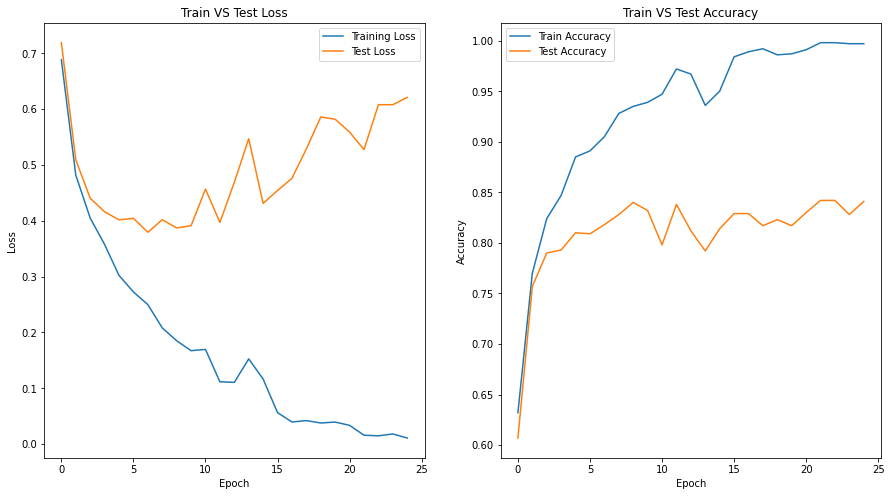

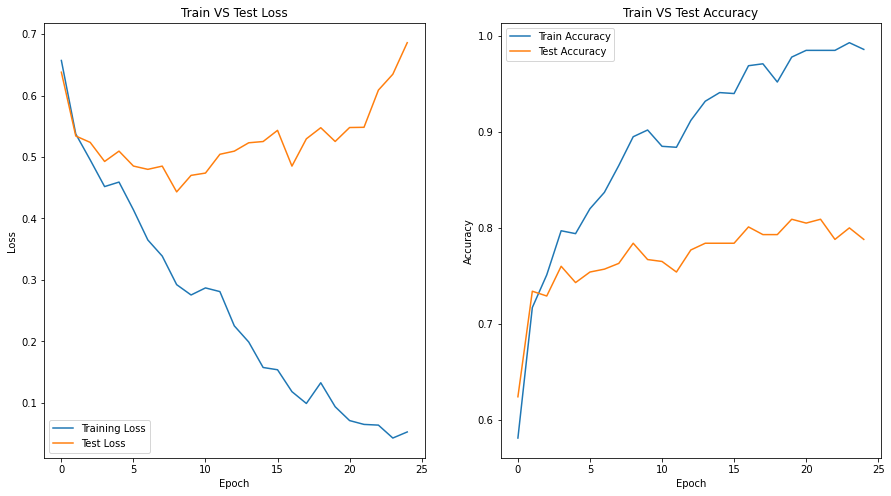

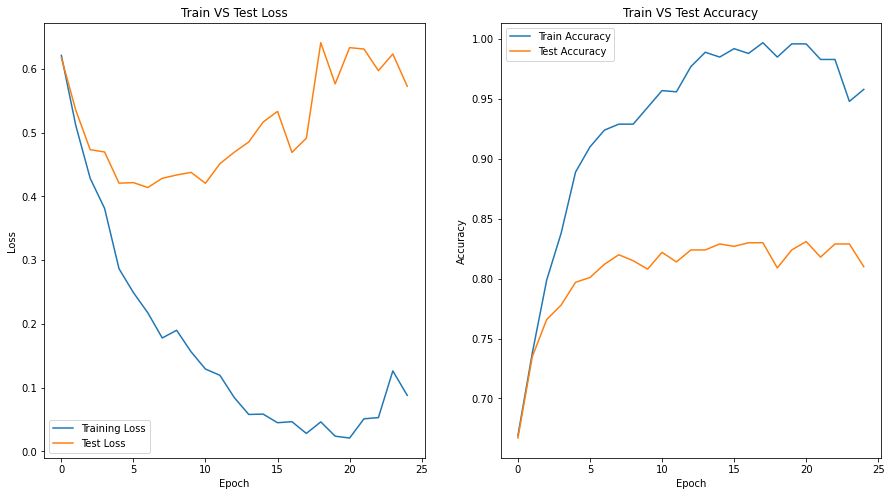

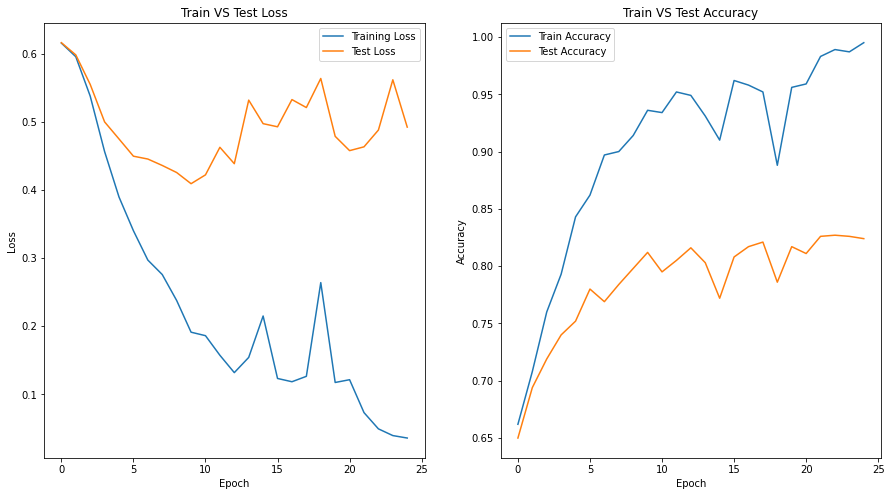

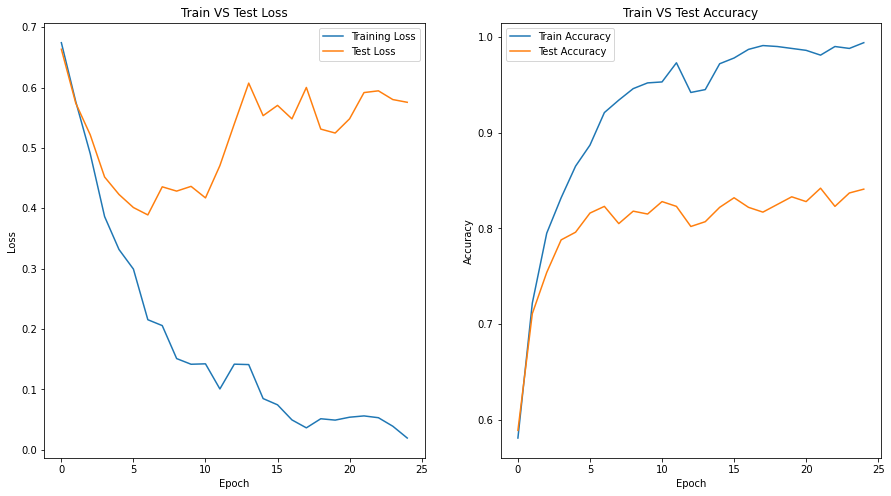

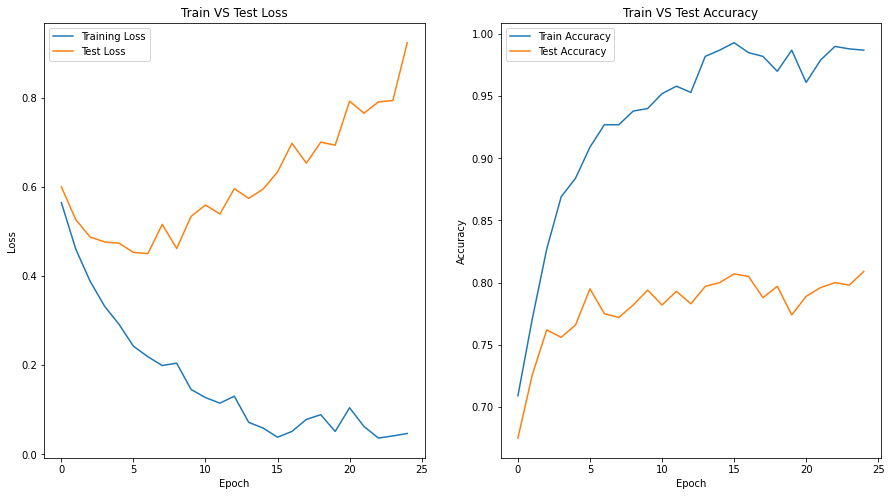

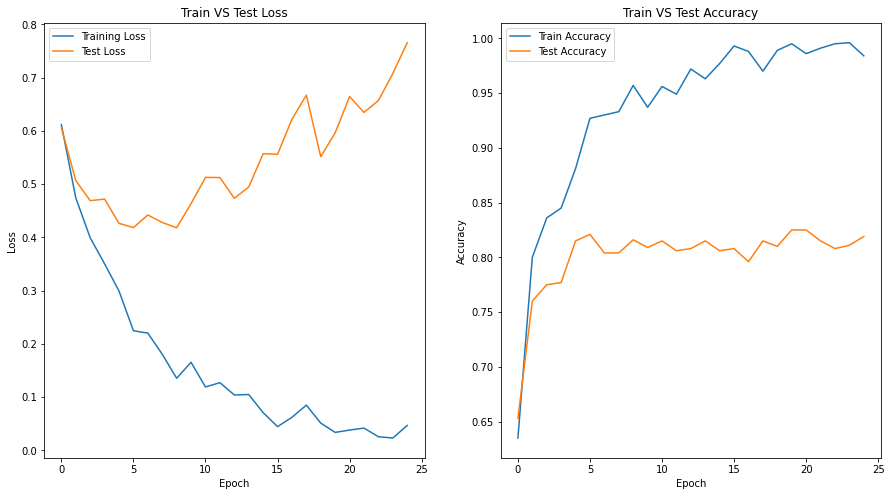

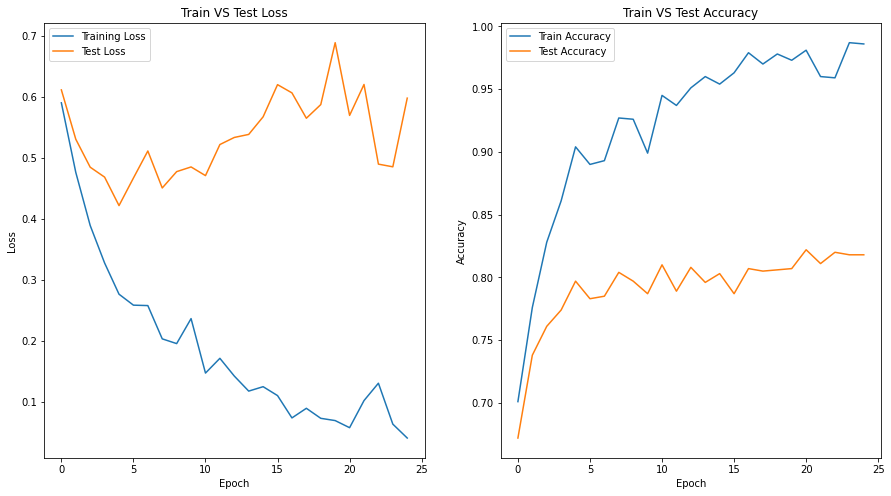

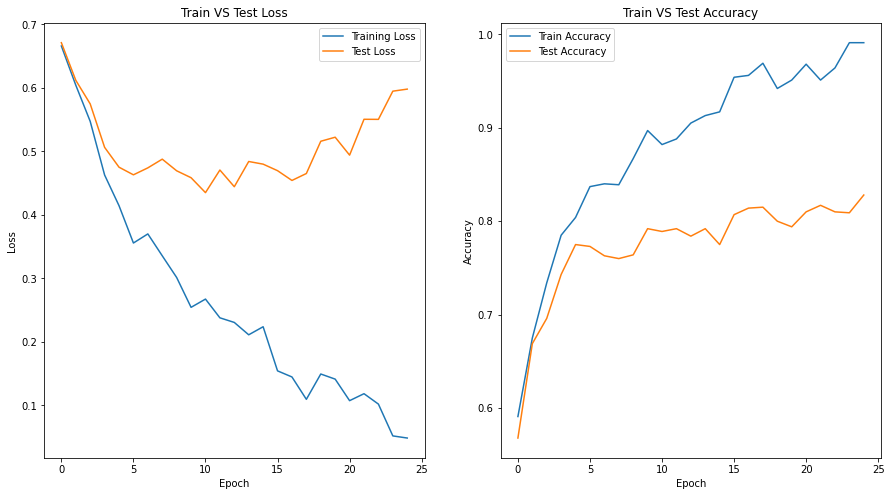

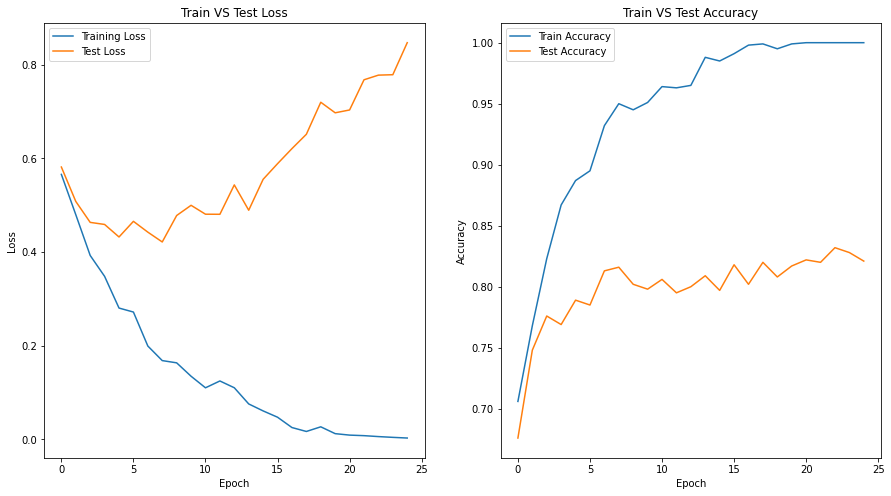

In [11]:
# calculate the standard deviation:
train_errors=[]
test_errors=[]
for num in range(10):
    N_PAIRS = 1000
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)
    my_model = CNN_Net_weight_sharing()
    # train the model
    my_model.trainer(train_input, train_target,test_input, test_target)
    train_errors.append(my_model.compute_error(train_input, train_target))
    test_errors.append(my_model.compute_error(test_input, test_target))

In [12]:
print('The standard deviation of train error:',np.std(train_errors))
print('The standard deviation of test error:',np.std(test_errors))
print('The mean of train error: ',np.mean(train_errors))
print('The mean of test error: ',np.mean(test_errors))

The standard deviation of train error: 0.011151678912607555
The standard deviation of test error: 0.014875826603022923
The mean of train error:  0.012199997901916504
The mean of test error:  0.1800999939441681


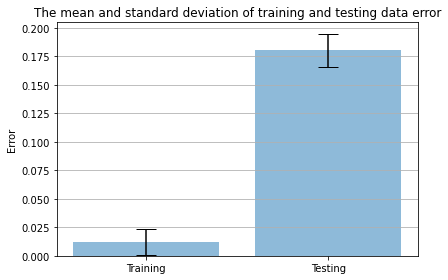

In [13]:
#plot the standard 
# Define labels, positions, bar heights and error bar heights
labels = ['Training', 'Testing']
x_pos = np.arange(len(labels))
means = [np.mean(train_errors), np.mean(test_errors)]
stds = [np.std(train_errors), np.std(test_errors)]
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means,
       yerr=stds,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('Error')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('The mean and standard deviation of training and testing data error')
ax.yaxis.grid(True)

# show the plot
plt.tight_layout()
plt.show()